# Задание № 5.1
# АА тест контрольной и экспериментальной групп

In [ ]:
# импортируем библиотеки

import pandahouse
from scipy import stats # Статистика
import seaborn as sns

In [78]:
# указываем параметры подключения к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}

In [79]:
# составляем запрос к данным в БД

q = """

SELECT DISTINCT exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-24' and '2023-04-30'
        and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

In [80]:
# вызываем запрос и сохраняем в df полученные данные
df = pandahouse.read_clickhouse(q, connection=connection)

In [81]:
#проверим равность выборки групп. Количество пользователей в обеих группах различаются незначительно.
df.groupby('exp_group').count()

,user_id,ctr
exp_group,,
2,8480,8480
3,8569,8569


In [82]:
# увеличили размер графика
sns.set(rc={'figure.figsize':(11.7,8.27)})

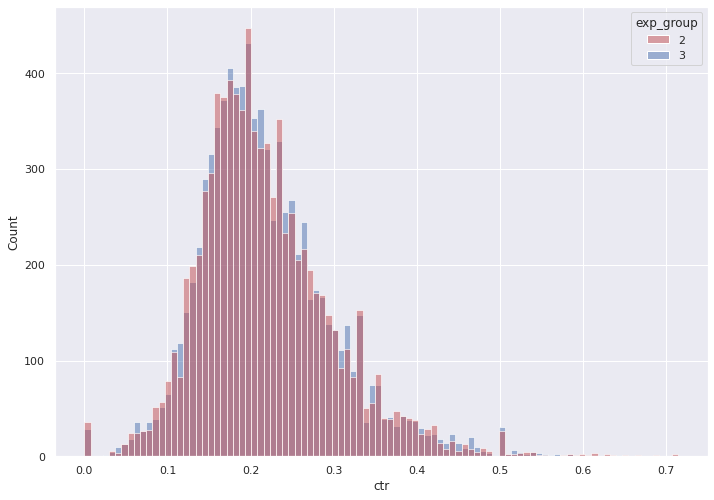

In [83]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Рапределение похоже на нормальное. На первый взгляд визуально ctr групп различаются не статистически значимо.

Проведем ttest 10 000 раз, каждый раз формирую новую подвыборку из 500 уникальных ctr в каждой группе. И проверим как часто ttest выдаст статистически значимые различия ctr в подвыбороках.

In [84]:
results = []
for _ in range (10000):
    results.append(stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500, replace=False),
                df[df.exp_group == 3].ctr.sample(500, replace=False),
                equal_var=False).pvalue)

Посмотрим на распределение pvalue, полученные в результате запуска 10 000 тестов. Распределения явно выраженное нормальное.

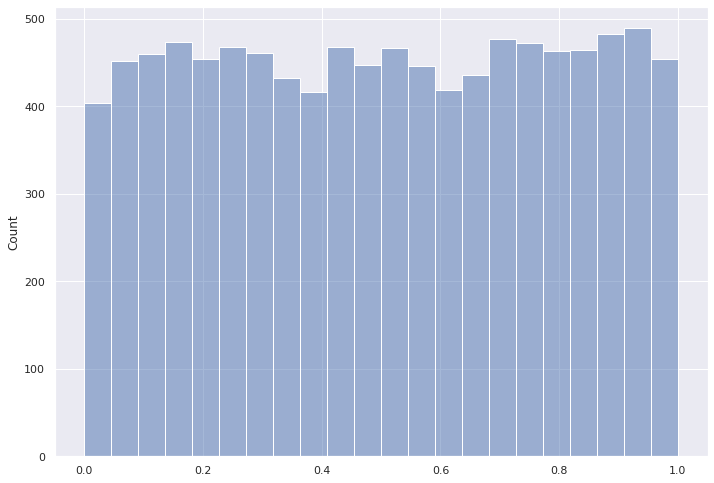

In [76]:
pval = sns.histplot(data = results, 
              alpha=0.5,
              kde=False)

In [ ]:
print(f' При проведении 10000 t-тестов только {len([i for i in results if i < 0.05]) * 100 / len(results) } % результатов показало стат.значимые различия ctr между группами 2 и 3')

Полученный результат позволяет нам предположить, что проведенное сплитование пользователей достигло поставленных целей, т.е. количество пользователей в группах значимо не отличается и показатели в группах (до выкатки нового функционала) также стат.значимо не отличаются.